# Analysis of Human Kidney Immunne (Lupus Nephritis vs. Healthy control)

## Data source: E-MTAB-13596

## **ScRNA-seq of human kidney immune cells of patients with ANCA-associated glomerulonephritis, Lupus Nephritis against a healthy nephrectomy control**

### "ANCA-associated glomerulonephritis (AGN) associates with a high risk of end-stage kidneydisease. The role of kidney immune cells in local inflammation remains unclear. Herewe investigate kidney immune cell diversity and function. Kidney tissue from AGN patients (n=5) and a lupus nephritis (LN) patient (n=1) were aquired during a biopsy procedure for a clinical indication. Needle-core biopsies were obtained for histopathological examination, and an additional pass was performed to retrieve kidney tissue for scRNA-seq. Healthy kidney tissue (n=1) was obtained from a kidney that was surgically removed do tue due to a (non-invasive) papillary urothelial carcinoma. Immediately after collection, kidney tissue was processed into a single-cell suspension and sorted using a 4-color flow cytometry panel to isolate living, CD45+immune cells. To aid in the multi-omic characterization, surface markers and T and B cell repertoires were sequenced in 2 samples (1 AGN patient and the nephrectomy control). These samples were incubated with an oligo-antibody TotalSeq-C cocktail containing 130 unique cell surface antigens."

In [2]:
PDIR = '/Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/'

# Convert raw data to AnnData object

## Parse metadata

In [3]:
import pandas as pd
sdrf_path = f"{PDIR}/lupus-emtab/raw-data/E-MTAB-13596.sdrf.txt"
print("Parsing SDRF metadata from:", sdrf_path)
sdrf = pd.read_csv(sdrf_path, sep="\t")

# Extract relevant columns and sample file info
samples = []
for idx, row in sdrf.iterrows():
    sample_id = row["Source Name"]
    disease = row["Characteristics[disease]"]
    cell_type = row["Characteristics[cell type]"]
    disease_stage = row.get("Characteristics[disease staging]", "")
    # Find corresponding matrix/barcode/features files in SDRF columns
    matrix_file = None
    barcode_file = None
    feature_file = None
    for col in sdrf.columns:
        if isinstance(row[col], str) and row[col].endswith("_matrix.mtx"):
            matrix_file = row[col]
        if isinstance(row[col], str) and row[col].endswith("_barcodes.tsv"):
            barcode_file = row[col]
        if isinstance(row[col], str) and row[col].endswith("_features.tsv"):
            feature_file = row[col]
    # Fallback: infer from sample_id
    if matrix_file is None:
        matrix_file = f"{sample_id}_matrix.mtx"
    if barcode_file is None:
        barcode_file = f"{sample_id}_barcodes.tsv"
    if feature_file is None:
        feature_file = f"{sample_id}_features.tsv"
    samples.append({
        "sample_id": sample_id,
        "disease": disease,
        "cell_type": cell_type,
        "disease_stage": disease_stage,
        "matrix_file": matrix_file,
        "barcode_file": barcode_file,
        "feature_file": feature_file,
    })

print(f"Found {len(samples)} samples in SDRF.")

Parsing SDRF metadata from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/E-MTAB-13596.sdrf.txt
Found 7 samples in SDRF.


## Load and annotate all samples

In [5]:
import scipy.io
from anndata.utils import make_index_unique
import pandas as pd
import scanpy as sc

adatas = []
for sample in samples:
    print(f"Loading sample {sample['sample_id']} ...")
    matrix_path = f"{PDIR}/lupus-emtab/raw-data/{sample['matrix_file']}"
    barcode_path = f"{PDIR}/lupus-emtab/raw-data/{sample['barcode_file']}"
    feature_path = f"{PDIR}/lupus-emtab/raw-data/{sample['feature_file']}"
    print(f"Loading matrix from: {matrix_path}")
    # Load matrix
    matrix = scipy.io.mmread(matrix_path)
    # Load barcodes
    barcodes = pd.read_csv(barcode_path, header=None)[0].tolist()
    # Load features
    features = pd.read_csv(feature_path, sep="\t", header=None)
    gene_names = features[1].tolist()  # column 1 is usually gene symbol
    # Check shape and transpose if needed
    if matrix.shape[0] == len(barcodes):
        matrix = matrix.tocsc()
    elif matrix.shape[1] == len(barcodes):
        matrix = matrix.T.tocsc()
    else:
        raise ValueError(f"Matrix dimensions {matrix.shape} do not match barcodes length {len(barcodes)} for sample {sample['sample_id']}.")
    # Diagnostic: check for unique barcodes
    prefixed_barcodes = [f"{sample['sample_id']}_" + bc for bc in barcodes]
    unique_barcodes = set(prefixed_barcodes)
    print(f"Sample {sample['sample_id']} - Total barcodes: {len(barcodes)}, Unique barcodes: {len(unique_barcodes)}")
    # Create AnnData
    ad = sc.AnnData(matrix)
    ad.obs_names = prefixed_barcodes
    ad.var_names = make_index_unique(pd.Index(gene_names))
    # Annotate sample metadata
    ad.obs["sample_id"] = sample["sample_id"]
    ad.obs["disease"] = sample["disease"]
    ad.obs["cell_type_sort"] = sample["cell_type"]
    ad.obs["disease_stage"] = sample["disease_stage"]
    ad.obs["batch"] = sample["sample_id"]
    adatas.append(ad)

print("Merging all samples into a single AnnData object...")
adata = adatas[0].concatenate(
    adatas[1:], batch_key="batch", batch_categories=[s["sample_id"] for s in samples]
)

print(f"Merged AnnData: {adata.n_obs} cells, {adata.n_vars} genes.")
print("AnnData .obs columns:", adata.obs.columns.tolist())
print("Preview of .obs (first 5 rows):")
print(adata.obs.head())

Loading sample AGN1 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN1_matrix.mtx
Sample AGN1 - Total barcodes: 6955, Unique barcodes: 6955
Loading sample AGN2 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN2_matrix.mtx
Sample AGN2 - Total barcodes: 3542, Unique barcodes: 3542
Loading sample AGN3 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN3_matrix.mtx
Sample AGN3 - Total barcodes: 5395, Unique barcodes: 5395
Loading sample AGN4 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN4_matrix.mtx
Sample AGN4 - Total barcodes: 1663, Unique barcodes: 1663
Loading sample AGN5 ...
Loading matrix from: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/raw-data/AGN5_matrix.mtx
Sample AGN5 - Total bar

/var/folders/p2/rh6xbt2n0nj6rn3qqpc7s1_m0000gn/T/ipykernel_4912/128507247.py:44: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(


Merged AnnData: 34993 cells, 20453 genes.
AnnData .obs columns: ['sample_id', 'disease', 'cell_type_sort', 'disease_stage', 'batch']
Preview of .obs (first 5 rows):
                             sample_id  \
AGN1_AAACCCAAGCACCAGA-1-AGN1      AGN1   
AGN1_AAACCCAAGGACAAGA-1-AGN1      AGN1   
AGN1_AAACCCAAGTCACAGG-1-AGN1      AGN1   
AGN1_AAACCCAAGTGCGACA-1-AGN1      AGN1   
AGN1_AAACCCACAAGCCATT-1-AGN1      AGN1   

                                                                     disease  \
AGN1_AAACCCAAGCACCAGA-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCAAGGACAAGA-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCAAGTCACAGG-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCAAGTGCGACA-1-AGN1  anti-neutrophil antibody associated vasculitis   
AGN1_AAACCCACAAGCCATT-1-AGN1  anti-neutrophil antibody associated vasculitis   

                                             cell_type_sort   disease_stage  \
AGN1_AAACCCAAGCACCAGA-

## Save AnnData object

In [6]:
# Save merged AnnData to .h5ad file in /input-data "lupus-emtab/input-data/emtab_merged.h5ad"
adata.write_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_merged.h5ad")

# Quality control and processing

In [7]:
adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_merged.h5ad")

In [22]:
# --- Quality Control (QC) ---
import os
qc_metrics_dir = f"{PDIR}/lupus-emtab/outputs/qc-metrics"
os.makedirs(qc_metrics_dir, exist_ok=True)
qc_metrics_path = os.path.join(qc_metrics_dir, "qc_metrics_emtab.csv")

print("Running quality control...")
sc.pp.filter_cells(adata, min_genes=200)
print(f"After min_genes filter: {adata.n_obs} cells")
sc.pp.filter_genes(adata, min_cells=3)
print(f"After min_cells filter: {adata.n_vars} genes")

# Mitochondrial filtering
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
print(f"Cells with <10% mito: {(adata.obs['pct_counts_mt'] < 10).sum()} / {adata.n_obs}")
adata = adata[adata.obs["pct_counts_mt"] < 10, :]
print(f"After mito filter: {adata.n_obs} cells")

# Save QC metrics
qc_metrics = adata.obs[[
    "n_genes_by_counts",
    "total_counts",
    "pct_counts_mt",
    "sample_id",
    "disease",
    "disease_stage",
]]
qc_metrics.to_csv(qc_metrics_path)
print(f"QC metrics saved to {qc_metrics_path}")

Running quality control...
After min_genes filter: 27734 cells
After min_cells filter: 16453 genes
Cells with <10% mito: 27167 / 27734
After mito filter: 27167 cells
QC metrics saved to /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade//lupus-emtab/outputs/qc-metrics/qc_metrics_emtab.csv


In [11]:
import numpy as np

# Remove cells with zero total counts before normalization
zero_count_cells = adata.X.sum(axis=1) == 0
print(f"Cells with zero total counts before normalization: {zero_count_cells.sum()}")
adata = adata[~zero_count_cells, :]

# Remove cells with any NaN values before normalization
import scipy.sparse
if scipy.sparse.issparse(adata.X):
    nan_cells = np.isnan(adata.X.toarray()).any(axis=1)
else:
    nan_cells = np.isnan(adata.X).any(axis=1)
print(f"Cells with NaN values before normalization: {nan_cells.sum()}")
adata = adata[~nan_cells, :]

Cells with zero total counts before normalization: 0
Cells with NaN values before normalization: 0


In [12]:
# Diagnostics: Check for negative values before normalization/log1p
print("Min value in adata.X before normalization:", adata.X.min())
print("Max value in adata.X before normalization:", adata.X.max())

# --- Save raw counts in .raw before normalization ---
print("Storing raw counts in .raw before normalization/log1p...")
adata.raw = adata.copy()

if adata.X.min() < 0:
    print("Data appears to be already log-transformed or scaled (contains negative values). Skipping normalization/log1p.")
else:
    print("Normalizing and log-transforming...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

# Remove cells with any NaN values after normalization/log1p
if scipy.sparse.issparse(adata.X):
    nan_cells_post = np.isnan(adata.X.toarray()).any(axis=1)
else:
    nan_cells_post = np.isnan(adata.X).any(axis=1)
print(f"Cells with NaN values after normalization/log1p: {nan_cells_post.sum()}")
adata = adata[~nan_cells_post, :]

Min value in adata.X before normalization: 0
Max value in adata.X before normalization: 7263
Storing raw counts in .raw before normalization/log1p...
Normalizing and log-transforming...
Cells with NaN values after normalization/log1p: 0


In [13]:
# --- HVG selection ---
print("Selecting highly variable genes...")
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# --- Scaling and PCA ---
print("Scaling and running PCA...")
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")

Selecting highly variable genes...


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:705: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/Users/aumchampaneri/.pyenv/versions/3.10.18/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Scaling and running PCA...


In [14]:
# --- Harmony batch correction ---
print("Running Harmony batch correction...")
import scanpy.external as sce

print("Harmony will use 'batch' column for integration. Unique batch values:", adata.obs["batch"].unique())
sce.pp.harmony_integrate(adata, "batch")

if "X_pca_harmony" in adata.obsm:
    print("Harmony-corrected PCA found. Using for downstream analysis.")
    print("Shape of X_pca_harmony:", adata.obsm["X_pca_harmony"].shape)
    print("Any NaNs in X_pca_harmony?", np.isnan(adata.obsm["X_pca_harmony"]).any())
    print("Min/Max in X_pca_harmony:", adata.obsm["X_pca_harmony"].min(), adata.obsm["X_pca_harmony"].max())
    adata.obsm["X_pca"] = adata.obsm["X_pca_harmony"]
else:
    print("WARNING: Harmony-corrected PCA not found. Using default PCA.")

Running Harmony batch correction...
Harmony will use 'batch' column for integration. Unique batch values: ['AGN1', 'AGN2', 'AGN3', 'AGN4', 'AGN5', 'LN', 'NC']
Categories (7, object): ['AGN1', 'AGN2', 'AGN3', 'AGN4', 'AGN5', 'LN', 'NC']


2026-02-06 09:23:50,167 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-02-06 09:23:54,691 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-06 09:23:54,753 - harmonypy - INFO - Iteration 1 of 10
2026-02-06 09:23:58,047 - harmonypy - INFO - Iteration 2 of 10
2026-02-06 09:24:01,411 - harmonypy - INFO - Iteration 3 of 10
2026-02-06 09:24:04,606 - harmonypy - INFO - Iteration 4 of 10
2026-02-06 09:24:07,255 - harmonypy - INFO - Iteration 5 of 10
2026-02-06 09:24:09,478 - harmonypy - INFO - Converged after 5 iterations


Harmony-corrected PCA found. Using for downstream analysis.
Shape of X_pca_harmony: (27736, 50)
Any NaNs in X_pca_harmony? False
Min/Max in X_pca_harmony: -31.86351810482223 61.63301464114909


In [15]:
# --- UMAP and clustering ---
print("Computing neighbors, UMAP, and clustering after Harmony...")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata)

Computing neighbors, UMAP, and clustering after Harmony...


/var/folders/p2/rh6xbt2n0nj6rn3qqpc7s1_m0000gn/T/ipykernel_4912/296598713.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


Displaying UMAP and PCA plots...


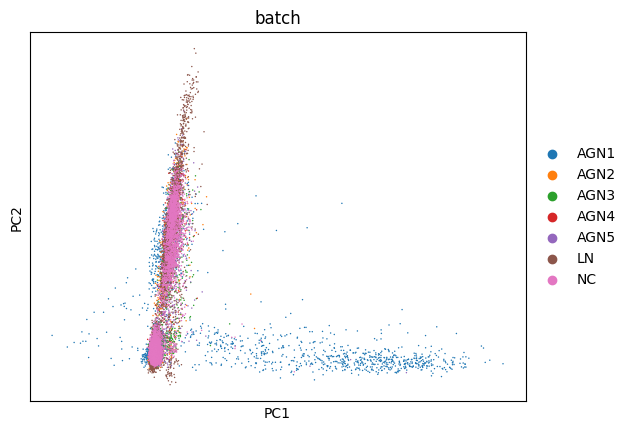

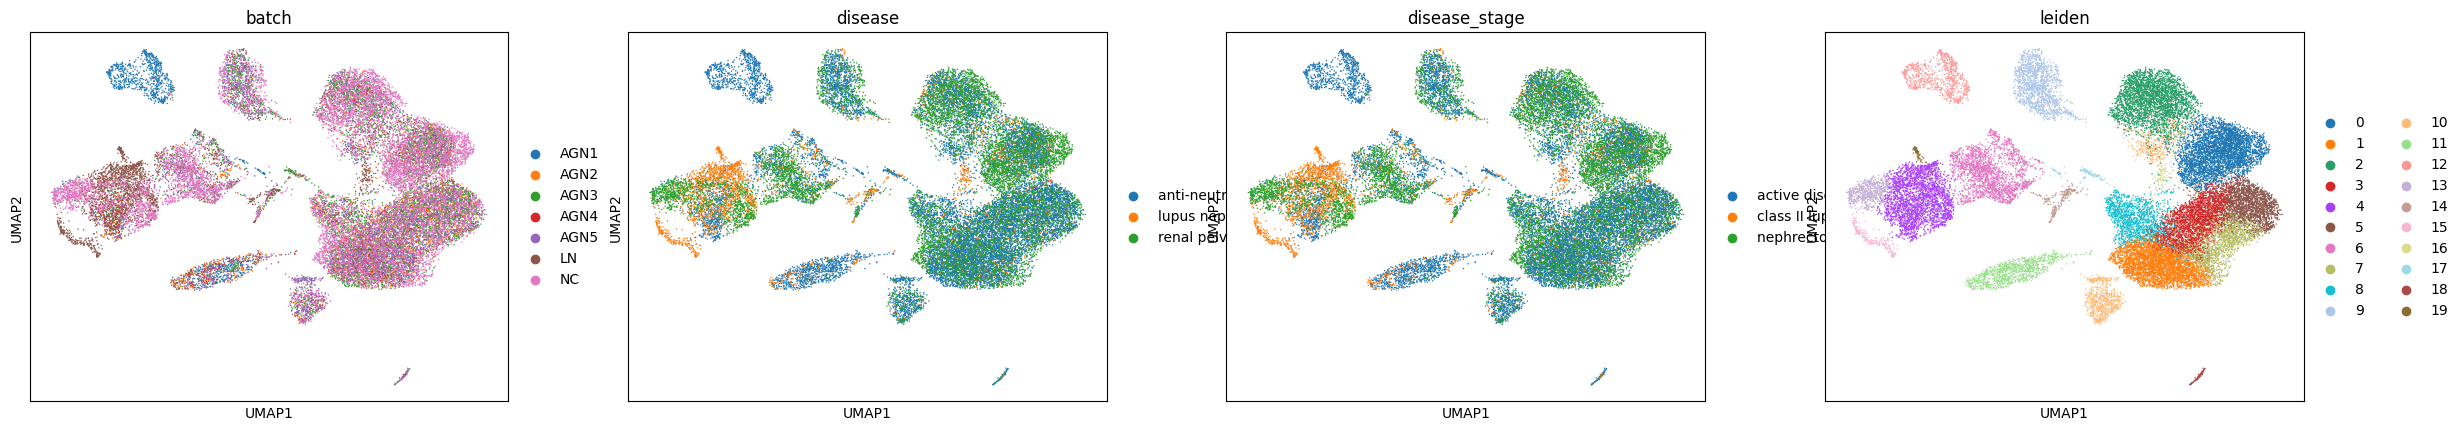

In [ ]:
# --- Save diagnostic plots (display in notebook) ---
print("Displaying UMAP and PCA plots...")
sc.pl.pca(adata, color="batch")
sc.pl.umap(
    adata,
    color=["batch", "disease", "disease_stage", "leiden"]
)

## Save AnnData Object

In [20]:
adata.write_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_processed.h5ad")

# Data exploration

In [23]:
adata = sc.read_h5ad(f"{PDIR}/lupus-emtab/input-data/lupus-emtab_processed.h5ad")

In [24]:
adata

AnnData object with n_obs × n_vars = 27736 × 16454
    obs: 'sample_id', 'disease', 'cell_type_sort', 'disease_stage', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'disease_colors', 'disease_stage_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [25]:
adata.obs

,sample_id,disease,cell_type_sort,disease_stage,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AGN1_AAACCCAAGGACAAGA-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,2099,2099,6441,513,7.964602,1
AGN1_AAAGAACAGGCATGGT-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,366,366,621,28,4.508857,11
AGN1_AAAGAACCAGTGAGCA-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,269,269,519,44,8.477842,11
AGN1_AAAGAACTCTCGCTTG-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,1716,1716,5058,296,5.852115,12
AGN1_AAAGGATAGACGGTCA-1-AGN1,AGN1,anti-neutrophil antibody associated vasculitis,CD45+ kidney immune cells AGN,active disease,AGN1,470,470,916,50,5.458515,11
...,...,...,...,...,...,...,...,...,...,...,...
NC_TTTGTCATCATAACCG-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,583,583,1213,11,0.906843,4
NC_TTTGTCATCCGCAGTG-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,2384,2384,8531,259,3.035986,6
NC_TTTGTCATCCTCAACC-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,1765,1765,6622,195,2.944730,13
NC_TTTGTCATCTTCCTTC-1-NC,NC,renal pelvis/ureter urothelial carcinoma,CD45+ kidney immune cells NC,nephrectomy control,NC,1055,1055,2069,49,2.368294,2


In [26]:
adata.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
AL627309.1,70,False,70,0.002704,99.747630,75,True,0.011738,2.550484,2.670733,0.003176,0.078515
FAM87B,20,False,20,0.000757,99.927894,21,False,0.001409,1.316943,-0.010329,0.000656,0.028838
LINC00115,568,False,568,0.021632,97.952194,600,False,0.045966,1.217209,-0.227098,0.022350,0.167254
FAM41C,166,False,166,0.006165,99.401521,171,False,0.009207,1.086072,-0.512120,0.004925,0.072129
AL645608.2,15,False,15,0.000541,99.945921,15,True,0.002082,2.174686,1.853949,0.000751,0.034496
...,...,...,...,...,...,...,...,...,...,...,...,...
AC145212.1,125,False,125,0.004867,99.549338,135,False,0.006012,0.916475,-0.880734,0.003393,0.057339
AC011043.1,322,False,322,0.014061,98.839096,390,False,0.020165,1.287499,-0.074325,0.010328,0.107104
AL592183.1,944,False,944,0.050366,96.596604,1397,False,0.066248,1.298230,-0.051003,0.033693,0.197150
AC011841.1,12,False,12,0.000505,99.956736,14,False,0.000359,-0.020574,-2.917382,0.000254,0.012774
